In [44]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from gensim.parsing.preprocessing import remove_stopwords, strip_numeric, strip_punctuation, strip_multiple_whitespaces, strip_short
from sklearn.metrics import confusion_matrix
import os

# Load model

In [45]:
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Load data clean

In [46]:
# Load the CSV file into a DataFrame
df_de = pd.read_csv('../Preprocessing/data_clean/labeled-data/labeled-de_clean_1-1.csv',sep = ';')
#df_en = pd.read_csv('../Preprocessing/data_clean/en_clean_1.csv')
df_en = pd.read_csv('../Preprocessing/data_clean/labeled-data/labeled-en_clean_1-1_not101010.csv')
#df_es = pd.read_csv('../Preprocessing/data_clean/en_clean_1.csv')
df_es = pd.read_csv('../Preprocessing/data_clean/labeled-data/labeled-es_clean_1-1.csv', sep = ';')


In [47]:
df_es['data'] = df_es['data'].apply(strip_punctuation)
df_es['data'] = df_es['data'].str.replace('xa', ' ')
df_es['data'] = df_es['data'].apply(strip_multiple_whitespaces)

df_de['data'] = df_de['data'].apply(strip_punctuation)
df_de['data'] = df_de['data'].apply(strip_multiple_whitespaces)

df_en['data'] = df_en['data'].apply(strip_punctuation)
df_en['data'] = df_en['data'].apply(strip_multiple_whitespaces)

# Sentiment Analysis

In [48]:
def sentiment_score(data):
    if isinstance(data, str):
        tokens = tokenizer.encode(data, return_tensors='pt')
        result = model(tokens)
        return int(torch.argmax(result.logits)) + 1
    else:
        return 0

In [49]:
df_de['sentiment'] = df_de['data'].apply(lambda x: sentiment_score(x[:512]))
df_en['sentiment'] = df_en['data'].apply(lambda x: sentiment_score(x[:512]))
df_es['sentiment'] = df_es['data'].apply(lambda x: sentiment_score(x[:512]))

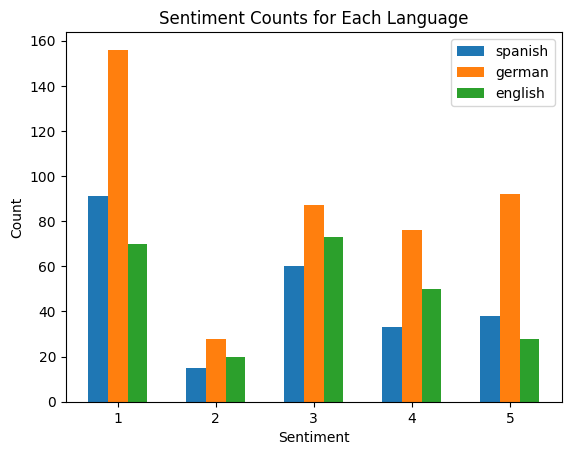

In [50]:
# Calculate the count of each sentiment category for each DataFrame
es_sentiment_counts = df_es['sentiment'].value_counts().sort_index()
de_sentiment_counts = df_de['sentiment'].value_counts().sort_index()
en_sentiment_counts = df_en['sentiment'].value_counts().sort_index()

# Set the x-axis labels
sentiment_labels = ['1', '2', '3', '4', '5']
x = np.arange(len(sentiment_labels))

# Set the width of each bar
bar_width = 0.2

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the counts for each sentiment category for each DataFrame
ax.bar(x - bar_width, es_sentiment_counts, width=bar_width, label='spanish')
ax.bar(x, de_sentiment_counts, width=bar_width, label='german')
ax.bar(x + bar_width, en_sentiment_counts, width=bar_width, label='english')

# Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(sentiment_labels)

# Set the plot title and labels
ax.set_title('Sentiment Counts for Each Language')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

# Add a legend
ax.legend()

# Show the plot
plt.show()

### Translate scores to positive, neutral and negative

In [51]:
sentiment_mapping = {1: 'negativ', 2: 'neutral', 3: 'neutral', 4: 'neutral', 5: 'positiv'}

# Replace the numbers with labels using the mapping
df_de['sentiment_label'] = df_de['sentiment'].map(sentiment_mapping)
df_en['sentiment_label'] = df_en['sentiment'].map(sentiment_mapping)
df_es['sentiment_label'] = df_es['sentiment'].map(sentiment_mapping)

### Save data

In [52]:
# Concatenate the dataframes vertically
merged_df = pd.concat([df_de, df_en, df_es], ignore_index=True)

# Create the folder if it doesn't exist
folder_name = 'data'

# Define the file path for saving the CSV
file_name = 'data_sentiment_final.csv'
file_path = os.path.join(folder_name, file_name)

# Convert the dataframe to CSV and save it
merged_df.to_csv(file_path, index=False)

### Drop unlabeled rows

In [53]:
# Drop rows where 'Label' is NaN or empty
df_de.dropna(subset=['Label'], inplace=True)
df_en.dropna(subset=['Label'], inplace=True)
df_es.dropna(subset=['Label'], inplace=True)

### Accuracy exact match positive, neutral and negative

In [54]:
# Calculate the accuracy
accuracy_de = (df_de['sentiment_label'] == df_de['Label']).mean() * 100
accuracy_en = (df_en['sentiment_label'] == df_en['Label']).mean() * 100
accuracy_es = (df_es['sentiment_label'] == df_es['Label']).mean() * 100

# Print the accuracy
print("Accuracy DE: {:.2f}%".format(accuracy_de))
print("Accuracy EN: {:.2f}%".format(accuracy_en))
print("Accuracy ES: {:.2f}%".format(accuracy_es))

Accuracy DE: 56.67%
Accuracy EN: 46.67%
Accuracy ES: 43.33%


In [55]:
def c_matrix(df):

    # Define the labels
    labels = ['positiv', 'neutral', 'negativ']

    # Create the confusion matrix
    cm = confusion_matrix(df['Label'], df['sentiment_label'], labels=labels)

    # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) as percentages
    total = np.sum(cm)
    tp_percent = (np.diag(cm) / total) * 100
    tn_percent = ((total - (np.sum(cm, axis=0) + np.sum(cm, axis=1) - np.diag(cm))) / total) * 100
    fp_percent = (np.sum(cm, axis=0) - np.diag(cm)) / total * 100
    fn_percent = (np.sum(cm, axis=1) - np.diag(cm)) / total * 100

    # Display the confusion matrix and calculations as percentages
    confusion_df = pd.DataFrame(cm, index=labels, columns=labels)
    confusion_df['True Positives (%)'] = tp_percent
    confusion_df['True Negatives (%)'] = tn_percent
    confusion_df['False Positives (%)'] = fp_percent
    confusion_df['False Negatives (%)'] = fn_percent
    return confusion_df

In [56]:
de_matrix = c_matrix(df_de)
de_matrix

,positiv,neutral,negativ,True Positives (%),True Negatives (%),False Positives (%),False Negatives (%)
positiv,4,3,3,13.333333,60.000000,6.666667,20.000000
neutral,1,8,1,26.666667,43.333333,23.333333,6.666667
negativ,1,4,5,16.666667,53.333333,13.333333,16.666667


In [57]:
en_matrix = c_matrix(df_en)
en_matrix

,positiv,neutral,negativ,True Positives (%),True Negatives (%),False Positives (%),False Negatives (%)
positiv,2,5,6,6.666667,50.000000,6.666667,36.666667
neutral,2,8,3,26.666667,40.000000,16.666667,16.666667
negativ,0,0,4,13.333333,56.666667,30.000000,0.000000


In [58]:
es_matrix = c_matrix(df_es)
es_matrix

,positiv,neutral,negativ,True Positives (%),True Negatives (%),False Positives (%),False Negatives (%)
positiv,0,5,5,0.000000,66.666667,0.000000,33.333333
neutral,0,8,2,26.666667,33.333333,33.333333,6.666667
negativ,0,5,5,16.666667,43.333333,23.333333,16.666667


# Save data

In [59]:
# Concatenate the dataframes vertically
#merged_df = pd.concat([df_de, df_en, df_es], ignore_index=True)

# Print the merged dataframe
#print(merged_df)

In [60]:
# Create the folder if it doesn't exist
#folder_name = 'data'

# Define the file path for saving the CSV
#file_name = 'data_sentiment_final.csv'
#file_path = os.path.join(folder_name, file_name)

# Convert the dataframe to CSV and save it
#merged_df.to_csv(file_path, index=False)